In [ ]:
import fitz
from typing import TypedDict, List, Annotated, Union
from langgraph.graph import StateGraph, START, END, add_messages
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from pydantic import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain.agents import tool, create_react_agent
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langgraph.prebuilt import ToolNode
from langchain_community.vectorstores import Chroma
from langgraph.checkpoint.memory import MemorySaver

from langchain_groq import ChatGroq

from IPython.display import Image, display
from langchain_text_splitters import RecursiveCharacterTextSplitter

#### 

#### State 

In [35]:
class Chatbot(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    # See the below flow
    messages: Annotated[list, add_messages]
    question_category : str
    llm_response : str
    documents: List[str]
    web_search_results: List[dict]

#### Initial state
state = {
    'messages': [
        HumanMessage(content="Add 7 and 3...")  
    ]
}

#### After first LLM response
state = {
    'messages': [
        HumanMessage(...),
        AIMessage(content="", tool_calls=[...]) 
    ]
}

#### After tool execution
state = {
    'messages': [
        HumanMessage(...),
        AIMessage(...),
        ToolMessage(...)  
    ]
}

#### Document Chunking

In [3]:
pdf_path = 'time-to-place-our-bets-europes-ai-opportunity.pdf'
doc = fitz.open(pdf_path)
texts = ''
for page in doc:
    texts = texts + page.get_text() + '\n'

In [4]:
text_splitter  = RecursiveCharacterTextSplitter(chunk_size = 800, chunk_overlap = 50)

chunks = text_splitter.create_documents([texts])

len(chunks)

69

#### Embeddings

In [5]:
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

C:\Users\USER\AppData\Local\Temp\ipykernel_3608\3701169180.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
c:\Users\adi\OneDrive\Work\genai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
db = Chroma.from_documents(documents = chunks, embedding = embeddings, collection_name='chunk_embedding')
retriever = db.as_retriever()

In [7]:
retriever.invoke("What is Europe's Gen AI strategy?")

[Document(metadata={}, page_content='understand the obligations introduced by the EU \nAI Act, and 70 percent find them to be complex. \nThat confusion has consequences. Meta, for \nexample, recently stopped the rollout of its \nmultimodal model in the EU, reportedly because \nof a lack of readability and predictability of the \nregulatory environment.59 This situation could \nchallenge the competitiveness of European \ncompanies by reducing their ability to access the \nworld’s most high-performing AI models.\nCreation of gen AI in Europe\nRegarding creating gen AI, winning in every \nsegment isn’t a realistic strategy for Europe. \nA differentiated approach, based on current \nstrengths, is crucial for the region to stay relevant. \nPotential steps include the following:\n\t\n— Increase investment. In 2023, US private'),
 Document(metadata={}, page_content='gen AI technologies extend well beyond LLMs. \n3\nTime to place our bets: Europe’s AI opportunity'),
 Document(metadata={}, page

#### Define Tools

In [8]:
tavily_search_tool = TavilySearchResults(tavily_api_key='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', max_results=5)

tavily_search_tool.invoke('tell me about AI and its applications')

[{'title': 'Applications of artificial intelligence (AI) - Google Cloud',
  'url': 'https://cloud.google.com/discover/ai-applications',
  'content': 'Artificial intelligence (AI) applications are software programs that use [AI techniques](https://cloud.google.com/learn/what-is-artificial-intelligence) to perform specific tasks. These tasks can range from simple, repetitive tasks to complex, cognitive tasks that require human-like intelligence. [...] *   **Disease diagnosis**: AI can be used to analyze patient data and identify patterns that may indicate a disease. This can help doctors diagnose diseases earlier and more accurately.\n*   **Treatment development**: By analyzing large datasets of patient data, AI can identify new patterns and relationships that can be used to develop new drugs and therapies.',
  'score': 0.75181264},
 {'title': 'Applications of artificial intelligence - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence',
  'conten

In [9]:
tools = [tavily_search_tool]

tools

[TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))]

#### Define LLM and bind it with tools

In [221]:
groq_api_key ='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'

groq_llm = ChatGroq(model='llama-3.3-70b-versatile', groq_api_key=groq_api_key , temperature = 0.0)

groq_llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A10DCCF0D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A10DCCF220>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [222]:
llm_with_tools = groq_llm.bind_tools(tools)
print(llm_with_tools)


bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002A10DCCF0D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002A10DCCF220>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search_results_json', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]} config={} config_factories=[]


In [223]:
question = 'tell me about google and its products in AI?'
response  = llm_with_tools.invoke(question)
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8hqq', 'function': {'arguments': '{"query":"Google AI products"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 288, 'total_tokens': 308, 'completion_time': 0.072727273, 'prompt_time': 0.01825739, 'queue_time': 0.05015679000000001, 'total_time': 0.090984663}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--3acae783-8512-40bd-af55-394165c0485d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Google AI products'}, 'id': 'call_8hqq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 288, 'output_tokens': 20, 'total_tokens': 308})

In [224]:
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'Google AI products'},
  'id': 'call_8hqq',
  'type': 'tool_call'}]

In [225]:
response.tool_calls[0]['id']

'call_8hqq'

In [226]:
tavily_results =tavily_search_tool.invoke(response.tool_calls[0]['args']['query'])
tavily_results


[{'title': "A guide to all of Google's AI products - Plus",
  'url': 'https://plusai.com/blog/a-guide-to-googles-ai-products',
  'content': '*   Gemini Nano, Pro, and Ultra - These are the latest AI models powering the various Google AI services. Originally, Bard used LaMDA, and Duet AI used PaLM and PaLM 2. But now all of the services use Gemini models.\n*   Google AI Studio - Formerly known as MakerSuite, this provides an easy-to-use environment to test out different AI models. [...] *   Vertex AI - This is the part of the Google Cloud console where you can manage your machine learning and AI services. It also has a playground-like environment, but the Google AI studio app is easier to use. [...] *   Gemini Advanced - This is the premium version of Google’s AI chatbot, and it comes with a subscription to use Gemini in Gmail, Docs, and the rest of the Google productivity suite. If you are looking to use AI with Google, it seems like this is the best subscription right now since it giv

In [227]:
tool_response = [tavily_result['content'] for tavily_result in tavily_results]
tool_response

['*   Gemini Nano, Pro, and Ultra - These are the latest AI models powering the various Google AI services. Originally, Bard used LaMDA, and Duet AI used PaLM and PaLM 2. But now all of the services use Gemini models.\n*   Google AI Studio - Formerly known as MakerSuite, this provides an easy-to-use environment to test out different AI models. [...] *   Vertex AI - This is the part of the Google Cloud console where you can manage your machine learning and AI services. It also has a playground-like environment, but the Google AI studio app is easier to use. [...] *   Gemini Advanced - This is the premium version of Google’s AI chatbot, and it comes with a subscription to use Gemini in Gmail, Docs, and the rest of the Google productivity suite. If you are looking to use AI with Google, it seems like this is the best subscription right now since it gives you the AI chat capabilities and the Workspace AI features.',
 '*   [Vision AI](https://cloud.google.com/vision)\n*   [Contact Center as

In [228]:
prompt_template = """You are an assistant for question-answering tasks who answers questions based 
on the search results context that are provided to you. 
Use the following pieces of search results to answer the question.
For every single search result, there is a url and content. Refer to the content for the response and also
mention the corresponding links of the results which you referred to. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
question: {question}
search_results: {context} 
Answer:
"""

prompt = ChatPromptTemplate.from_template(prompt_template)

web_search_chain = prompt | groq_llm 

chain_response = web_search_chain.invoke({'question': question,
                                 'context': tavily_results})

print(chain_response)

content='Google offers various AI products, including Gemini models, Google AI Studio, and Vertex AI, which provide easy-to-use environments to test out different AI models (https://plusai.com/blog/a-guide-to-googles-ai-products). Google Cloud also offers a range of AI and machine learning products, such as Vision AI, Contact Center as a Service, and Vertex AI Agent Builder (https://cloud.google.com/products/ai). Additionally, Google provides free usage of many AI products up to monthly limits, including Translation, Speech-to-Text, and Natural Language (https://cloud.google.com/use-cases/free-ai-tools).' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 127, 'prompt_tokens': 1525, 'total_tokens': 1652, 'completion_time': 0.461818182, 'prompt_time': 0.106050928, 'queue_time': 0.050692871999999986, 'total_time': 0.56786911}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None} id='run--37e25

In [229]:
print(chain_response.content)

Google offers various AI products, including Gemini models, Google AI Studio, and Vertex AI, which provide easy-to-use environments to test out different AI models (https://plusai.com/blog/a-guide-to-googles-ai-products). Google Cloud also offers a range of AI and machine learning products, such as Vision AI, Contact Center as a Service, and Vertex AI Agent Builder (https://cloud.google.com/products/ai). Additionally, Google provides free usage of many AI products up to monthly limits, including Translation, Speech-to-Text, and Natural Language (https://cloud.google.com/use-cases/free-ai-tools).


#### State

In [298]:
class Chatbot(TypedDict):
    messages: List[str]
    question_category : str
    llm_response : str
    documents: List[str]
    web_search_results: List[dict]
    relevant_docs_grade : str

#### Nodes

#### Question Route Classification

In [276]:
class QuestionClassification(BaseModel):
    '''CLassify a user query to the most relevant path for response generation.'''

    category: str = Field(description="Depending upon user question classify it into vector_store or web_search")

In [277]:
def question_classify_util(question):

    question_classify_system = """You're an expert at routing a user question to a vector store or web search.
    The vectorstore contains documents related to Europe's competitive position and opportunities in the 
    generative AI value chain, covering sectors like AI semiconductor manufacturing, cloud infrastructure, 
    and energy demands.

    Return **vector_store** for questions around these topics else return **web_search**.

    Return only one of the two categories from above. Don't return any explaination of response.
    """

    get_classify_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', question_classify_system),
            ('human',"{question}")
        ]
    )

    question_classify_llm_structured = groq_llm.with_structured_output(QuestionClassification)

    question_classify_llm = get_classify_prompt | question_classify_llm_structured

    question_classify_llm_response = question_classify_llm.invoke({'question': question})

    return question_classify_llm_response.category

In [278]:
def question_classification(state: Chatbot):

    question = state['messages'][-1].content

    print(f'question-->{question}')

    # question = 'How much of Europe’s productivity growth can generative AI potentially contribute annually by 2030?'

    # question = 'What is capital of India?'

    question_category = question_classify_util(question)

    state['question_category'] = question_category

    return state
    

##### Quetion Router

In [279]:
def question_router(state: Chatbot):
    if state['question_category'] == "web_search":
        return "retrieve_docs"
    return "tool_node"

##### Retrieve docs from Vector Store

In [280]:
def retrieve_docs(state: Chatbot):

    question = state['messages'][-1].content
    
    retrieved_docs = retriever.invoke(question)

    state['documents'] = retrieved_docs
    
    return state

##### Documents Grader

In [299]:
class GradeDocument(BaseModel):
    """Boolean values to check for relevance on retrieved documents."""

    score: str = Field(description="Documents are relevant to the question, 'Yes' or 'No'")

In [300]:
def doc_grader_util(question, relevant_docs):
    
    doc_grader_system = """You are a grader assessing relevance of a retrieved document to a user question. \n
        If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
        Give a binary score 'Yes' or 'No' score to indicate whether the document is relevant to the question."""

    doc_grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", doc_grader_system),
            (
                "human","Retrieved document: \n\n {document} \n\n User question: {question}",
            ),
        ]
    )

    structured_llm = groq_llm.with_structured_output(GradeDocument)
    doc_grader_llm = doc_grade_prompt | structured_llm
    scores = []
    for doc in relevant_docs:
        result = doc_grader_llm.invoke({"document": doc, "question": question})
        scores.append(result.score)

    return scores

In [301]:
def doc_grader(state:Chatbot):

    question = state['messages'][-1].content
    relevant_docs = state['documents']

    scores = doc_grader_util(question, relevant_docs)
    state["relevant_docs_grade"] = scores

    return state


In [ ]:
def retrieve_docs(state: Chatbot):

    question = state['messages'][-1].content
    
    retrieved_docs = retriever.invoke(question)

    state['documents'] = retrieved_docs
    
    return state

##### Web Search Tool

In [281]:
def tool_node_util(question):
    
    response  = llm_with_tools.invoke(question)

    if len(response.tool_calls)>0:

        tavily_results =tavily_search_tool.invoke(response.tool_calls[0]['args']['query'])
    
        return tavily_results

In [282]:
def tool_node(state:Chatbot):
    
    question = state['messages'][-1].content
    
    tavily_results = tool_node_util(question)

    tool_response = [ToolMessage(content= tavily_result['content'], tool_call_id = 'web_search') for tavily_result in tavily_results]

    #print(f'before web_search_results\n-->{state}\n')

    #print(f'tool response----{tool_response}\n')

    state['messages'].extend(tool_response)

    # print(f'\nafter extend too response-->{state}\n')
    
    # tool_call_id = tool_response.tool_calls[0]['id'])

    state['web_search_results'] = tavily_results

    #print(f'\nafter web_search_results-->{state}\n')

    return state

    

##### Generate LLM response

##### 1) from Web Search

In [283]:
def generate_answer_web_search(state:Chatbot):
  
     question = state['messages'][-1].content
     tavily_results = state['web_search_results']
        
     prompt_template = """You are an assistant for question-answering tasks who answers questions based 
     on the search results that are provided to you. 
     Use the following pieces of search results to answer the question.
     For every single search result, there is a url and content. Refer to the content for the response and also
     mention the corresponding links of the results which you referred to. 
     If you don't know the answer, just say that you don't know. 
     Use three sentences maximum and keep the answer concise.
     question: {question}
     search_results: {tavily_results} 
     """

     prompt = ChatPromptTemplate.from_template(prompt_template)

     web_search_chain = prompt | groq_llm | StrOutputParser()

     llm_response = web_search_chain.invoke({'question': question,
                                        'tavily_results': tavily_results})

     state['messages'].append(AIMessage(content=llm_response))
     
     state['llm_response'] = llm_response

     print(f'generate_answer_web_search-->{state}')

     return state


##### 2) from Vector Store

In [284]:
def generate_answer_vector_store(state:Chatbot):

     question = state['messages'][-1].content
     documents = state['documents']

     prompt_template = """Answer the question only based on the context provided;.
     question: {question}
     context: {context} 
     """

     prompt = ChatPromptTemplate.from_template(prompt_template)

     web_search_chain = prompt | groq_llm | StrOutputParser()

     llm_response = web_search_chain.invoke({'question': question,
                                        'context': documents})
     
     state['messages'].append(AIMessage(content=llm_response))

     state['llm_response'] = llm_response

     print(f'generate_answer_vector_store-->{state}')

     return state

#### Memory Checkpoint

In [285]:
memory =  MemorySaver()

#### Graph Building

In [ ]:
graph = StateGraph(Chatbot)

graph.add_node('question_classification', question_classification)
graph.add_node('retrieve_docs', retrieve_docs)
graph.add_node('tool_node', tool_node)
graph.add_node('generate_answer_web_search', generate_answer_web_search)
graph.add_node('generate_answer_vector_store', generate_answer_vector_store)


graph.add_conditional_edges("question_classification", question_router, 
                            {
                                "retrieve_docs":"retrieve_docs",
                                "tool_node":"tool_node"
                            }
                            )

graph.add_edge('tool_node', 'generate_answer_web_search')
graph.add_edge('retrieve_docs', 'generate_answer_vector_store')


graph.add_edge('generate_answer_web_search', END)

graph.add_edge('generate_answer_vector_store', END)

graph.set_entry_point('question_classification')

workflow = graph.compile(checkpointer=memory)

config = {"configurable":{"thread_id": 1}}


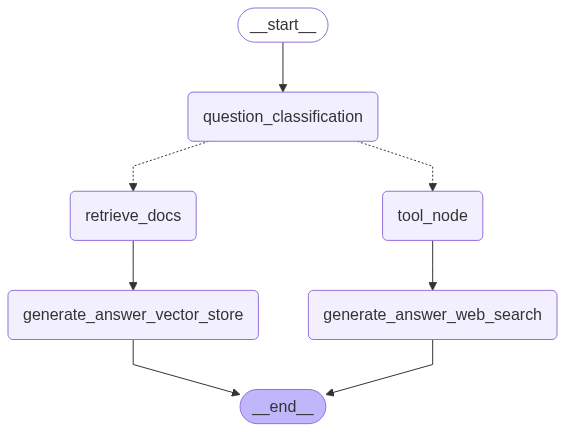

In [287]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [288]:
messages = [HumanMessage(content="tell me about ai adoption in europe")]
response = workflow.invoke({"messages": messages}, config=config)
response

question-->tell me about ai adoption in europe
generate_answer_web_search-->{'messages': [HumanMessage(content='tell me about ai adoption in europe', additional_kwargs={}, response_metadata={}), ToolMessage(content='## Europe-based respondents to a Deloitte survey report higher levels of strategy, tech, and talent preparedness for generative AI adoption, and less progress in the areas of risk and governance\n\nThe preparedness of some European organizations to adopt generative AI appears to be accelerating rapidly, but fewer gains are being made in the areas of risk management, regulatory readiness, and governance models. [...] According to a Deloitte survey of over 700 senior leaders in France, Germany, Italy, the Netherlands, Spain, and the United Kingdom conducted in June 2024, there was a significant increase over the previous six months in respondents reporting that their organizations are highly prepared or very highly prepared to adopt gen AI in the areas of strategy (up 11 perc

{'messages': [HumanMessage(content='tell me about ai adoption in europe', additional_kwargs={}, response_metadata={}),
  ToolMessage(content='## Europe-based respondents to a Deloitte survey report higher levels of strategy, tech, and talent preparedness for generative AI adoption, and less progress in the areas of risk and governance\n\nThe preparedness of some European organizations to adopt generative AI appears to be accelerating rapidly, but fewer gains are being made in the areas of risk management, regulatory readiness, and governance models. [...] According to a Deloitte survey of over 700 senior leaders in France, Germany, Italy, the Netherlands, Spain, and the United Kingdom conducted in June 2024, there was a significant increase over the previous six months in respondents reporting that their organizations are highly prepared or very highly prepared to adopt gen AI in the areas of strategy (up 11 percentage points since December 2023), technology and infrastructure (up 9 pe

In [289]:
response['messages']

[HumanMessage(content='tell me about ai adoption in europe', additional_kwargs={}, response_metadata={}),
 ToolMessage(content='## Europe-based respondents to a Deloitte survey report higher levels of strategy, tech, and talent preparedness for generative AI adoption, and less progress in the areas of risk and governance\n\nThe preparedness of some European organizations to adopt generative AI appears to be accelerating rapidly, but fewer gains are being made in the areas of risk management, regulatory readiness, and governance models. [...] According to a Deloitte survey of over 700 senior leaders in France, Germany, Italy, the Netherlands, Spain, and the United Kingdom conducted in June 2024, there was a significant increase over the previous six months in respondents reporting that their organizations are highly prepared or very highly prepared to adopt gen AI in the areas of strategy (up 11 percentage points since December 2023), technology and infrastructure (up 9 percentage point

In [290]:
print(response['llm_response'])

For governments, secure adoption of the technology, responsible AI education, and continued investment in skill-building through public-private partnerships are critical priorities. This is according to the article "Bridging The AI Divide: Why Europe's AI Future Depends ..." (https://www.forbes.com/sites/bernardmarr/2025/03/14/bridging-the-ai-divide-why-europes-ai-future-depends-on-transformative-innovation/). Europe has strong foundations for AI success, with robust research capabilities, strong institutions, and public sector adoption, as mentioned in the same article.


In [291]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

tell me about ai adoption in europe
================================= Tool Message =================================

## Europe-based respondents to a Deloitte survey report higher levels of strategy, tech, and talent preparedness for generative AI adoption, and less progress in the areas of risk and governance

The preparedness of some European organizations to adopt generative AI appears to be accelerating rapidly, but fewer gains are being made in the areas of risk management, regulatory readiness, and governance models. [...] According to a Deloitte survey of over 700 senior leaders in France, Germany, Italy, the Netherlands, Spain, and the United Kingdom conducted in June 2024, there was a significant increase over the previous six months in respondents reporting that their organizations are highly prepared or very highly prepared to adopt gen AI in the areas of strategy (up 11 percentage points sinc

In [292]:
messages = [HumanMessage(content="give me a detailed explaination")]
response = workflow.invoke({"messages": messages}, config=config)
response

question-->give me a detailed explaination
generate_answer_vector_store-->{'messages': [HumanMessage(content='give me a detailed explaination', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the provided context, I will give a detailed explanation of the topic that appears to be the focus of the documents: the gap between Europe and the US in terms of data centers, cloud computing, supercomputing, and AI/IT spending.\n\nThe documents highlight that European data centers are largely owned by US companies, with European cloud companies such as OVH and UpCloud having only about 5% global market share, compared to over 70% for US players like Amazon Web Services, Google, and Microsoft. This disparity is also reflected in the supercomputing capacity, with Europe having only half the capacity of the US in terms of flop/s, which is essential for basic and applied research.\n\nOne of the reasons for this gap is the emergence of private players in the US specializing i

{'messages': [HumanMessage(content='give me a detailed explaination', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the provided context, I will give a detailed explanation of the topic that appears to be the focus of the documents: the gap between Europe and the US in terms of data centers, cloud computing, supercomputing, and AI/IT spending.\n\nThe documents highlight that European data centers are largely owned by US companies, with European cloud companies such as OVH and UpCloud having only about 5% global market share, compared to over 70% for US players like Amazon Web Services, Google, and Microsoft. This disparity is also reflected in the supercomputing capacity, with Europe having only half the capacity of the US in terms of flop/s, which is essential for basic and applied research.\n\nOne of the reasons for this gap is the emergence of private players in the US specializing in supercomputing, such as CoreWeave, whereas European supercomputers are

In [293]:
response['llm_response']

'Based on the provided context, I will give a detailed explanation of the topic that appears to be the focus of the documents: the gap between Europe and the US in terms of data centers, cloud computing, supercomputing, and AI/IT spending.\n\nThe documents highlight that European data centers are largely owned by US companies, with European cloud companies such as OVH and UpCloud having only about 5% global market share, compared to over 70% for US players like Amazon Web Services, Google, and Microsoft. This disparity is also reflected in the supercomputing capacity, with Europe having only half the capacity of the US in terms of flop/s, which is essential for basic and applied research.\n\nOne of the reasons for this gap is the emergence of private players in the US specializing in supercomputing, such as CoreWeave, whereas European supercomputers are mostly located in research centers. Additionally, the operating costs of European data centers are typically more than 50% higher, whi

In [294]:
response['documents']

[Document(metadata={}, page_content='these European data centers are owned by \nUS companies.27 In 2023, European cloud \ncompanies (for example, OVH and UpCloud) \nhad about 5 percent market share globally \n(about 15 percent in Europe), while US players \n(for example, Amazon Web Services, Google, \nand Microsoft) had more than 70 percent global \nmarket share.28 Furthermore, Europe has only \nhalf the supercomputing capacity in flop/s,29 \nwhich is increasingly necessary in basic and \napplied research.30 This is partially because \nthe United States has seen the emergence \nof private players specializing in this segment \n(for example, CoreWeave), while Europe \nsupercomputers mostly lie in research centers. \nWhat’s more, the operating costs of European \ndata centers are typically more than 50 percent'),
 Document(metadata={}, page_content='Designed by McKinsey Global Publishing \nCopyright © 2024 McKinsey & Company. All rights reserved.\nAlexander Sukharevsky, a global leader o

In [270]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

give me a detailed explaination
================================== Ai Message ==================================

Based on the provided context, I will give a detailed explanation of the topic that appears to be the focus of the documents: the gap between Europe and the US in terms of data centers, cloud computing, supercomputing, and AI/IT spending.

The documents highlight that European data centers are largely owned by US companies, with European cloud companies such as OVH and UpCloud having only about 5% global market share, compared to over 70% for US players like Amazon Web Services, Google, and Microsoft. This disparity is also reflected in the supercomputing capacity, with Europe having only half the capacity of the US in terms of flop/s, which is essential for basic and applied research.

One of the reasons for this gap is the emergence of private players in the US specializing in supercomputing

In [296]:
messages = [HumanMessage(content="tell me products developed by germany in AI")]
response = workflow.invoke({"messages": messages}, config=config)
response

question-->tell me products developed by germany in AI
generate_answer_web_search-->{'messages': [HumanMessage(content='tell me products developed by germany in AI', additional_kwargs={}, response_metadata={}), ToolMessage(content='With [a strong presence in Germany](https://techround.co.uk/business/most-promising-industries-in-germany/), Aristek has developed AI-powered CRM systems and smart automation tools that optimise workflows and enhance customer engagement. Their bespoke AI development capabilities are particularly attractive to enterprises looking for end-to-end digital transformation.\n\n### Instinctools\n\n### insinctools\n\n![insinctools](https://techround.co.uk/wp-content/uploads/2025/04/insinctools.png) [...] Some of the top AI companies in Germany include Lateral, Innovacio Technologies, Aristek Systems, Instinctools, Vention, Plavno, OpenXcell and Indium, all of which are taking part in redefining what’s possible with artificial intelligence.\n\nThese are the top 8 AI c

{'messages': [HumanMessage(content='tell me products developed by germany in AI', additional_kwargs={}, response_metadata={}),
  ToolMessage(content='With [a strong presence in Germany](https://techround.co.uk/business/most-promising-industries-in-germany/), Aristek has developed AI-powered CRM systems and smart automation tools that optimise workflows and enhance customer engagement. Their bespoke AI development capabilities are particularly attractive to enterprises looking for end-to-end digital transformation.\n\n### Instinctools\n\n### insinctools\n\n![insinctools](https://techround.co.uk/wp-content/uploads/2025/04/insinctools.png) [...] Some of the top AI companies in Germany include Lateral, Innovacio Technologies, Aristek Systems, Instinctools, Vention, Plavno, OpenXcell and Indium, all of which are taking part in redefining what’s possible with artificial intelligence.\n\nThese are the top 8 AI companies in Germany.\n\n### Lateral\n\n![lateral-logo](https://techround.co.uk/wp-

In [19]:
tool_node = ToolNode(tools=tools, messages_key="messages")

In [12]:
def llm_response(state:React):
    messages = state['messages']

    state['messages'] = [llm_with_tools.invoke(messages)]

    return state

In [13]:
def tool_router(state:React):
    last_message = state['messages'][-1]
    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

In [14]:
graph = StateGraph(React)

graph.add_node('llm_response', llm_response)
graph.add_node('tool_node', tool_node)

graph.add_conditional_edges("llm_response", tool_router, 
                            {
                                "tool_node":"tool_node",
                                END:END
                            }
                            )

graph.add_edge('tool_node', 'llm_response')

graph.set_entry_point('llm_response')

graph_builder = graph.compile()


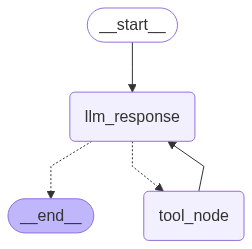

In [15]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [19]:
messages = [HumanMessage(content="tell me about meta and its relation with facebook")]
messages = graph_builder.invoke({"messages": messages})

messages['messages']

[HumanMessage(content='tell me about meta and its relation with facebook', additional_kwargs={}, response_metadata={}, id='f452ba5b-835a-4c1a-8a5f-696d0020cef5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wmg4', 'function': {'arguments': '{"query":"meta and its relation with facebook"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1004, 'total_tokens': 1096, 'completion_time': 0.167272727, 'prompt_time': 0.057564556, 'queue_time': 0.242246788, 'total_time': 0.224837283}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1659f53a-7ecf-4194-8c67-cef855da4a8a-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'meta and its relation with facebook'}, 'id': 'call_wmg4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1004, 'output_tokens': 92, 'total_tokens': 1096})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

tell me about meta and its relation with facebook
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_wmg4)
 Call ID: call_wmg4
  Args:
    query: meta and its relation with facebook
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Facebook and the creation of the metaverse: radical business model ...", "url": "https://www.emerald.com/insight/content/doi/10.1108/ijebr-12-2021-0984/full/html", "content": "Our study is a preliminary endeavor to understand the BM transition from Facebook to Meta. The rapid growth of Facebook over the last decades has shaped one of the most prominent entrepreneurial success stories. By advancing a strong vision to build the metaverse, Meta has once again demonstrated a strong entrepreneurial behavior in announcing that the c

In [22]:
messages = [HumanMessage(content="why they rebranded?")]
messages = graph_builder.invoke({"messages": messages})

messages['messages']

[HumanMessage(content='why they rebranded?', additional_kwargs={}, response_metadata={}, id='52386b92-406d-4478-a59b-b682aaa4838e'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a5e6', 'function': {'arguments': '{"query":"why did google rebrand to tavily"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 1000, 'total_tokens': 1092, 'completion_time': 0.167272727, 'prompt_time': 0.042864524, 'queue_time': 0.24564991599999997, 'total_time': 0.210137251}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--29222637-995a-417f-8ed1-17af13b463de-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'why did google rebrand to tavily'}, 'id': 'call_a5e6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1000, 'output_tokens': 92, 'total_tokens': 1092}),
 ToolMessage(content='[{"t

In [79]:
messages['messages'][1]#.pretty_print()

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0f37', 'function': {'arguments': '{"a":3,"b":4}', 'name': 'multiplication'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 1269, 'total_tokens': 1356, 'completion_time': 0.158181818, 'prompt_time': 0.058711005, 'queue_time': 0.27019943500000004, 'total_time': 0.216892823}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--499d920d-9344-48dc-bd35-a8a243f69496-0', tool_calls=[{'name': 'multiplication', 'args': {'a': 3, 'b': 4}, 'id': 'call_0f37', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1269, 'output_tokens': 87, 'total_tokens': 1356})

In [80]:
hasattr(messages['messages'][1], "tool_calls"), messages['messages'][1].tool_calls

(True,
 [{'name': 'multiplication',
   'args': {'a': 3, 'b': 4},
   'id': 'call_0f37',
   'type': 'tool_call'}])

In [81]:
hasattr(messages['messages'][-1], "tool_calls"), messages['messages'][-1].tool_calls

(True, [])